# Description

The notebook helps to investigate the differences between prod and sim pnl differences.

# Imports

In [1]:
import logging

import core.config as cconfig
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hprint as hprint
import reconciliation.sim_prod_reconciliation as rsiprrec

/app/amp/core/statistics/random_samples.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-1bb2736a-8582-4d99-8a81-8565e9783237.json'
INFO  # Git
  branch_name='CmTask5298_PnL_curves_diverge_in_paper_trading_runs'
  hash='908b15d7f'
  # Last commits:
    * 908b15d7f PomazkinG checkpoint                                                        ( 8 minutes ago) Mon Sep 11 19:36:24 2023  (HEAD -> CmTask5298_PnL_curves_diverge_in_paper_trading_runs)
    * 6ad258d55 Nina Lee checkpoint                                                        (    3 days ago) Fri Sep 8 17:47:28 2023  (origin/CmTask5298_PnL_curves_diverge_in_paper_trading_runs)
    * 119d7dc82 Nina Lee checkpoint                                                        (    3 days ago) Fri Sep 8 17:27:50 2023           
# Machine info
  system=Linux
  node name=c46db3c846d1
  release=5.15.0-1043-aws
  version=#48~20.04.1-Ubuntu SMP Wed Aug 16 18:26:32 UTC 2023
  machine=x86_64
  processor=x86_64
  cpu count=8

# Build config

In [3]:
config = {
    "bar_duration": "5T",
    "portfolio_path_dict": {
        "prod": "/shared_data/ecs/preprod/prod_reconciliation/C3a/paper_trading/20230904_131000.20230905_130500/prod/system_log_dir.scheduled/process_forecasts/portfolio",
        "sim": "/shared_data/ecs/preprod/prod_reconciliation/C3a/paper_trading/20230904_131000.20230905_130500/simulation/system_log_dir/process_forecasts/portfolio",
    },
}
config = cconfig.Config().from_dict(config)
print(config)

bar_duration: 5T
portfolio_path_dict: 
  prod: /shared_data/ecs/preprod/prod_reconciliation/C3a/paper_trading/20230904_131000.20230905_130500/prod/system_log_dir.scheduled/process_forecasts/portfolio
  sim: /shared_data/ecs/preprod/prod_reconciliation/C3a/paper_trading/20230904_131000.20230905_130500/simulation/system_log_dir/process_forecasts/portfolio


# Compare prod vs sim PnL

In [4]:
# Load portfolios.
portfolio_dfs, portfolio_stats_dfs = rsiprrec.load_portfolio_dfs(
    config["portfolio_path_dict"].to_dict(),
    config["bar_duration"],
)

INFO  Processing portfolio=prod path=/shared_data/ecs/preprod/prod_reconciliation/C3a/paper_trading/20230904_131000.20230905_130500/prod/system_log_dir.scheduled/process_forecasts/portfolio


Loading `holdings_shares` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `holdings_notional` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `executed_trades_shares` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `executed_trades_notional` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `statistics` files...:   0%|          | 0/288 [00:00<?, ?it/s]

INFO  Processing portfolio=sim path=/shared_data/ecs/preprod/prod_reconciliation/C3a/paper_trading/20230904_131000.20230905_130500/simulation/system_log_dir/process_forecasts/portfolio


Loading `holdings_shares` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `holdings_notional` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `executed_trades_shares` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `executed_trades_notional` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `statistics` files...:   0%|          | 0/288 [00:00<?, ?it/s]

In [5]:
# Differences between PnL data.
prod_portfolio_pnl = portfolio_dfs["prod"]["pnl"].sum(axis=1, min_count=1)
sim_portfolio_pnl = portfolio_dfs["sim"]["pnl"].sum(axis=1, min_count=1)
portfolio_pnl_diff = prod_portfolio_pnl - sim_portfolio_pnl
# Pick the bar 13:20 to spot-check.
portfolio_pnl_diff.sort_values(ascending=False).head(3)

2023-09-04 13:20:00-04:00    0.409120
2023-09-05 03:00:00-04:00    0.345660
2023-09-04 13:15:00-04:00    0.290036
dtype: float64

<Axes: >

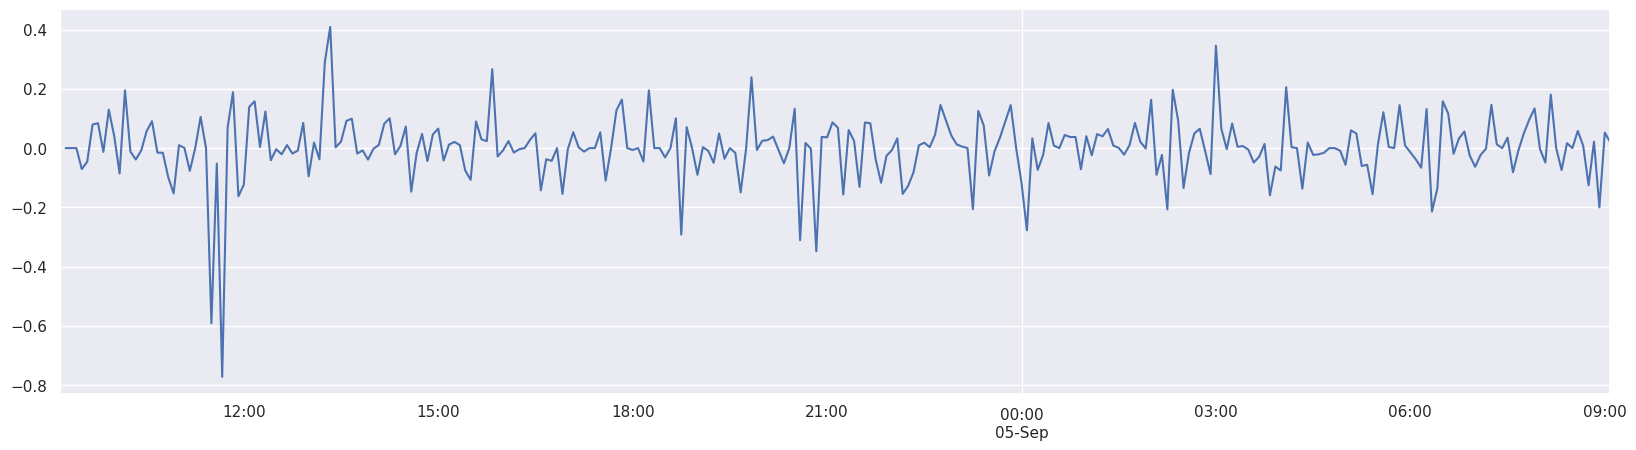

In [6]:
portfolio_pnl_diff.plot()

In [7]:
portfolio_dfs["sim"]["executed_trades_notional"].loc["2023-09-04 13:20:00-04:00"]

6051632686     123.500800
8717633868     -49.415000
2540896331    -189.117600
1528092593      96.628560
8968126878     250.133120
1467591036   -1191.262920
2476706208    -119.825520
5115052901     193.521060
3065029174      90.427936
1891737434       0.000000
3401245610      50.988800
1464553467    -892.952338
1966583502     114.672480
1030828978     -15.705500
2601760471    -174.494978
2683705052     -20.925840
9872743573     191.713600
2484635488     -79.394000
2099673105    -180.370400
4516629366     136.918060
2237530510     -77.960000
2425308589    -130.757760
1776791608       0.000000
2384892553     -25.598416
5118394986     399.951600
Name: 2023-09-04 13:20:00-04:00, dtype: float64

In [8]:
# For asset_ids 1891737434 and 1776791608 executed trades are NaN while
# for simulation they are zeros.
portfolio_dfs["prod"]["executed_trades_notional"].loc["2023-09-04 13:20:00-04:00"]

6051632686     123.500800
8717633868     -49.415000
2540896331    -189.117600
1528092593      96.628560
8968126878     250.133120
1467591036   -1191.262920
2476706208    -119.825520
5115052901     193.521060
1891737434            NaN
3401245610      50.988800
1464553467    -892.952338
1966583502     114.672480
1030828978     -15.705500
2601760471    -174.494978
2683705052     -20.925840
9872743573     191.713600
2484635488     -79.394000
2099673105    -180.370400
4516629366     136.918060
2237530510     -77.960000
2384892553     -25.598416
5118394986     399.951600
3065029174      90.427936
2425308589    -130.757760
1776791608            NaN
Name: 2023-09-04 13:20:00-04:00, dtype: float64

<Axes: >

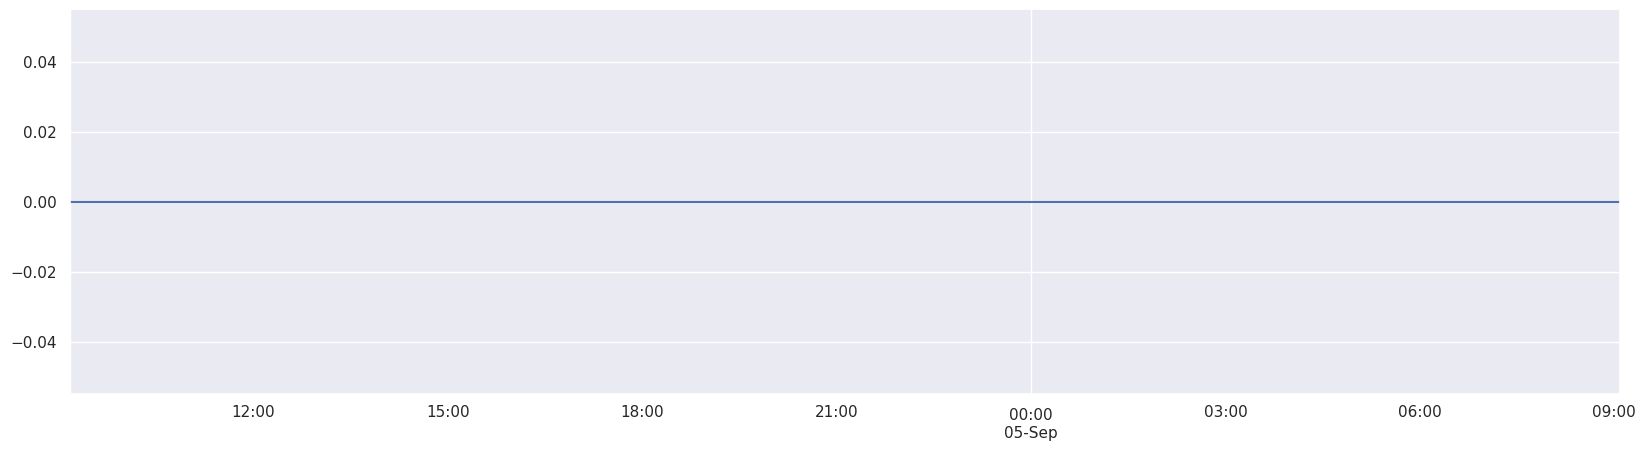

In [9]:
# Fill NaNs with zeros for prod `executed_trades_notional` when computing pnl.
prod_pnl = (
    portfolio_dfs["prod"]["holdings_notional"]
    .diff()
    .subtract(portfolio_dfs["prod"]["executed_trades_notional"].fillna(0))
    .sum(axis=1)
)
# Keep the sim portfolio as-is since NaNs are already filled with zeros.
sim_pnl = (
    portfolio_dfs["sim"]["holdings_notional"]
    .diff()
    .subtract(portfolio_dfs["sim"]["executed_trades_notional"])
    .sum(axis=1)
)
# After the fix there is no difference between sim and prod pnl.
diff_pnl = prod_pnl - sim_pnl
diff_pnl.plot()